<a href="https://colab.research.google.com/github/jhubar/master-thesis/blob/main/LayoutLMv2/CORD/Fine_tuning_lr5e5_LayoutLMv2ForTokenClassification_on_CORD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv2ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv2 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv2 model very powerful for document understanding tasks.

LayoutLMv2 is itself an upgrade of LayoutLM. The main novelty of LayoutLMv2 is that it also pre-trains visual embeddings, whereas the original LayoutLM only adds visual embeddings during fine-tuning.

* Paper: https://arxiv.org/abs/2012.14740
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv2

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv2. For that, check out the notebook "Prepare CORD for LayoutLMv2".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.



## Install dependencies

First, we install the required libraries:
* Transformers (for the LayoutLMv2 model)
* Datasets (for data preprocessing)
* Seqeval (for metrics)
* Detectron2 (which LayoutLMv2 requires for its visual backbone).



In [94]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers 

Cloning into 'transformers'...
remote: Enumerating objects: 99900, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 99900 (delta 87), reused 114 (delta 66), pack-reused 99730
Receiving objects: 100% (99900/99900), 89.41 MiB | 28.32 MiB/s, done.
Resolving deltas: 100% (73242/73242), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [95]:
!pip install -q datasets seqeval

In [96]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [98]:
import pandas as pd
cord_folder_path = '/content/drive/MyDrive/CORD-2/'
cord_folder_output_path = '/content/drive/MyDrive/CORD-2/cord_base_lr_5e5/'
cord_pickel_folder_path = cord_folder_path+'pickel'
train = pd.read_pickle(cord_pickel_folder_path+'/train.pkl')
val = pd.read_pickle(cord_pickel_folder_path+'/dev.pkl')
test = pd.read_pickle(cord_pickel_folder_path+'/test.pkl')

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [99]:
from collections import Counter

all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'menu.cnt': 2379,
         'menu.discountprice': 401,
         'menu.etc': 19,
         'menu.itemsubtotal': 7,
         'menu.nm': 6475,
         'menu.num': 109,
         'menu.price': 2535,
         'menu.sub_cnt': 183,
         'menu.sub_etc': 9,
         'menu.sub_nm': 792,
         'menu.sub_price': 156,
         'menu.sub_unitprice': 14,
         'menu.unitprice': 733,
         'menu.vatyn': 9,
         'sub_total.discount_price': 184,
         'sub_total.etc': 279,
         'sub_total.othersvc_price': 6,
         'sub_total.service_price': 347,
         'sub_total.subtotal_price': 1448,
         'sub_total.tax_price': 1261,
         'total.cashprice': 1366,
         'total.changeprice': 1271,
         'total.creditcardprice': 405,
         'total.emoneyprice': 129,
         'total.menuqty_cnt': 614,
         'total.menutype_cnt': 123,
         'total.total_etc': 81,
         'total.total_price': 2089,
         'void_menu.nm': 3,
         'void_menu.price': 1})

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [100]:
replacing_labels = {'menu.etc': 'O', 'mneu.itemsubtotal': 'O', 'menu.sub_etc': 'O', 'menu.sub_unitprice': 'O', 'menu.vatyn': 'O',
                  'void_menu.nm': 'O', 'void_menu.price': 'O', 'sub_total.othersvc_price': 'O'}

In [101]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]
train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]

In [102]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'O': 61,
         'menu.cnt': 2379,
         'menu.discountprice': 401,
         'menu.itemsubtotal': 7,
         'menu.nm': 6475,
         'menu.num': 109,
         'menu.price': 2535,
         'menu.sub_cnt': 183,
         'menu.sub_nm': 792,
         'menu.sub_price': 156,
         'menu.unitprice': 733,
         'sub_total.discount_price': 184,
         'sub_total.etc': 279,
         'sub_total.service_price': 347,
         'sub_total.subtotal_price': 1448,
         'sub_total.tax_price': 1261,
         'total.cashprice': 1366,
         'total.changeprice': 1271,
         'total.creditcardprice': 405,
         'total.emoneyprice': 129,
         'total.menuqty_cnt': 614,
         'total.menutype_cnt': 123,
         'total.total_etc': 81,
         'total.total_price': 2089})

Now we have to save all the unique labels in a list.

In [103]:
labels = list(set(all_labels))
print(labels)

['sub_total.discount_price', 'total.total_etc', 'menu.itemsubtotal', 'menu.cnt', 'menu.sub_price', 'total.menuqty_cnt', 'total.emoneyprice', 'total.menutype_cnt', 'menu.unitprice', 'menu.price', 'O', 'sub_total.subtotal_price', 'total.changeprice', 'sub_total.etc', 'total.total_price', 'menu.nm', 'total.cashprice', 'total.creditcardprice', 'menu.num', 'sub_total.service_price', 'menu.sub_cnt', 'sub_total.tax_price', 'menu.sub_nm', 'menu.discountprice']


In [104]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'sub_total.discount_price': 0, 'total.total_etc': 1, 'menu.itemsubtotal': 2, 'menu.cnt': 3, 'menu.sub_price': 4, 'total.menuqty_cnt': 5, 'total.emoneyprice': 6, 'total.menutype_cnt': 7, 'menu.unitprice': 8, 'menu.price': 9, 'O': 10, 'sub_total.subtotal_price': 11, 'total.changeprice': 12, 'sub_total.etc': 13, 'total.total_price': 14, 'menu.nm': 15, 'total.cashprice': 16, 'total.creditcardprice': 17, 'menu.num': 18, 'sub_total.service_price': 19, 'menu.sub_cnt': 20, 'sub_total.tax_price': 21, 'menu.sub_nm': 22, 'menu.discountprice': 23}
{0: 'sub_total.discount_price', 1: 'total.total_etc', 2: 'menu.itemsubtotal', 3: 'menu.cnt', 4: 'menu.sub_price', 5: 'total.menuqty_cnt', 6: 'total.emoneyprice', 7: 'total.menutype_cnt', 8: 'menu.unitprice', 9: 'menu.price', 10: 'O', 11: 'sub_total.subtotal_price', 12: 'total.changeprice', 13: 'sub_total.etc', 14: 'total.total_price', 15: 'menu.nm', 16: 'total.cashprice', 17: 'total.creditcardprice', 18: 'menu.num', 19: 'sub_total.service_price', 20: 'm

In [105]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class CORDDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = processor(image, words, boxes=boxes, word_labels=word_labels,
                              padding="max_length", truncation=True, max_length=512, return_token_type_ids=True,return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [106]:
from transformers import LayoutLMv2Processor,AutoTokenizer 
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)  # apply_ocr is set to True by default
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)



train_dataset = CORDDataset(annotations=train,
                            image_dir=cord_folder_path+'train/image/', 
                            processor=processor)
val_dataset = CORDDataset(annotations=val,
                            image_dir=cord_folder_path+'dev/image/', 
                            processor=processor)
test_dataset = CORDDataset(annotations=test,
                            image_dir=cord_folder_path+'test/image/', 
                            processor=processor)

Next, we create corresponding dataloaders.

In [107]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

373
47
47


## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [108]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
 
  return results,out_label_list, preds_list

In [109]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
print(torch.cuda.get_device_name(0))
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased",
                                                                      num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

Tesla V100-SXM2-16GB


Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.stem.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.5.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.7.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv1.norm.num_batches_tracked', '

In [110]:


global_step = 0
num_train_epochs = 4

val_iterator = iter(val_dataloader)
global_step = 0
train_loss = []
val_loss = []
val_precision = []
val_recall = []
val_f1 = []
preds_val = None
out_label_ids = None
batch_logits_array = []
out_label_list=[]
preds_list=[]
#put the model in training mode
val_batch_idx = 0
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   loop = tqdm(train_dataloader, leave=True)
   for batch_id, batch in enumerate(loop):
        model.train() 
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        
        # Testing part
        if val_batch_idx >= len(val_iterator):
            val_iterator = iter(val_dataloader)
            val_batch_idx = 0
        val_batch_idx += 1
        model.eval()
        with torch.no_grad():
            batch = next(val_iterator)
            input_ids = batch['input_ids'].to(device)
            bbox = batch['bbox'].to(device)
            image = batch['image'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            # forward pass
            outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                            token_type_ids=token_type_ids, labels=labels)
            if preds_val is None:
                preds_val = outputs.logits.detach().cpu().numpy()
                out_label_ids = batch["labels"].detach().cpu().numpy()
            else:
                preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0)
       

        
        loss = outputs.loss
        val_loss.append(loss.item())
         
        if global_step % 100 == 0 or global_step == 0:
            val_result,out_label_l,preds_l = results_test(preds_val, out_label_ids, list(set(all_labels)))
            val_precision.append(val_result['precision'])
            val_recall.append(val_result['recall'])
            val_f1.append(val_result['f1'])


        
            
            print("Overall results:", val_result)
            print(f"Loss after {global_step} steps: {train_loss[-1]}")
            print("Validation loss: {}".format(loss.item()))
        global_step += 1



model.save_pretrained(cord_folder_output_path +"check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = cord_folder_output_path +'model/large_model_xlm_btt_qv_lr_star_1e5.pt'
torch.save(model, path_model)

# define data
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(cord_folder_output_path + '/output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(cord_folder_output_path + '/output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(cord_folder_output_path + '/output/classification_reports.csv')

Epoch: 0


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Loss after 0 steps: 3.175973415374756
Validation loss: 3.1501691341400146
Overall results: {'precision': 0.5205761316872428, 'recall': 0.501984126984127, 'f1': 0.5111111111111111}
Loss after 100 steps: 1.7549176216125488
Validation loss: 1.6150286197662354
Overall results: {'precision': 0.6696483025005082, 'recall': 0.6491919590067008, 'f1': 0.6592614830381267}
Loss after 200 steps: 1.2304359674453735
Validation loss: 1.3497483730316162
Overall results: {'precision': 0.7235560433529976, 'recall': 0.7026378896882494, 'f1': 0.712943562014194}
Loss after 300 steps: 1.3721904754638672
Validation loss: 0.7940775156021118
Epoch: 1


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.7544329896907217, 'recall': 0.7328259563388744, 'f1': 0.7434725185410951}
Loss after 400 steps: 0.9265272617340088
Validation loss: 2.169989824295044
Overall results: {'precision': 0.7724369472649852, 'recall': 0.753735517379145, 'f1': 0.7629716504226149}
Loss after 500 steps: 0.5048491954803467
Validation loss: 1.1420546770095825
Overall results: {'precision': 0.7881413755458515, 'recall': 0.7697074698474046, 'f1': 0.778815359201699}
Loss after 600 steps: 0.8606996536254883
Validation loss: 0.8627287149429321
Overall results: {'precision': 0.8014229894442176, 'recall': 0.7845846417356551, 'f1': 0.79291443078876}
Loss after 700 steps: 0.7437532544136047
Validation loss: 0.32365351915359497
Epoch: 2


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.8103008669046405, 'recall': 0.7948576859586814, 'f1': 0.8025049872477968}
Loss after 800 steps: 0.6273745894432068
Validation loss: 0.8950583338737488
Overall results: {'precision': 0.8174868825764429, 'recall': 0.8037088095343976, 'f1': 0.8105392981275928}
Loss after 900 steps: 0.4214012920856476
Validation loss: 0.5822328925132751
Overall results: {'precision': 0.825690686414127, 'recall': 0.8116226052873655, 'f1': 0.8185962081484469}
Loss after 1000 steps: 0.493206650018692
Validation loss: 0.17781007289886475
Overall results: {'precision': 0.8334626898769265, 'recall': 0.8199469148820129, 'f1': 0.8266495601173022}
Loss after 1100 steps: 0.23736125230789185
Validation loss: 0.20811116695404053
Epoch: 3


  0%|          | 0/373 [00:00<?, ?it/s]

Overall results: {'precision': 0.839374724492218, 'recall': 0.8255736392742796, 'f1': 0.8324169819251787}
Loss after 1200 steps: 0.7690966129302979
Validation loss: 0.08840686082839966
Overall results: {'precision': 0.8450638138138138, 'recall': 0.8323832999537821, 'f1': 0.8386756282694068}
Loss after 1300 steps: 0.7157995104789734
Validation loss: 0.11334546655416489
Overall results: {'precision': 0.8503259452411995, 'recall': 0.8384709882010113, 'f1': 0.844356857216836}
Loss after 1400 steps: 0.19870513677597046
Validation loss: 0.0835065096616745


FileNotFoundError: ignored

In [111]:
model.save_pretrained(cord_folder_output_path +"check_points/LargeCheckpoints_xlm_lr_1e5")
path_model = cord_folder_output_path +'model/large_model_xlm_btt_qv_lr_star_1e5.pt'
torch.save(model, path_model)

# define data
data_loss = pd.DataFrame({'batch_loss_array': train_loss,'val_loss':val_loss})
data_loss.to_csv(cord_folder_output_path + '/output/logits_btt_qv_large_star_lr_1e5.csv')
data_loss = pd.DataFrame({'precison':val_precision,'recall':val_recall,'f1':val_f1})
data_loss.to_csv(cord_folder_output_path + '/output/metrics.csv')
data_loss = pd.DataFrame({'preds_list':preds_list,'out_label_list':out_label_list})
data_loss.to_csv(cord_folder_output_path + '/output/classification_reports.csv')

## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

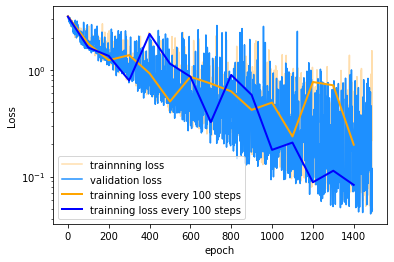

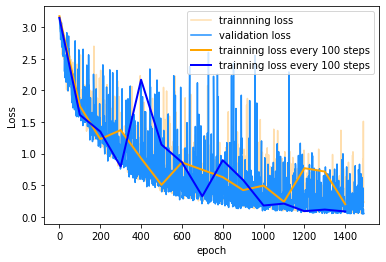

In [112]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 



x_avg_train_loss = []
y_avg_train_loss = []
x_avg_val_loss = []
y_avg_val_loss = []

x_val_precision = []
y_val_precision = []

x_avg_val_recall = []
y_avg_val_recall = []

x_avg_val_f1 = []
y_avg_val_f1 = []

for i in range(0,len(train_loss)):
   if i%100==0:
      x_avg_train_loss.append(i)
      y_avg_train_loss.append(train_loss[i]) 

for i in range(0,len(val_loss)):
   if i%100==0:
      x_avg_val_loss.append(i)
      y_avg_val_loss.append(val_loss[i]) 
      

for i in range(0,len(val_loss)):
  if i%100==0:
    try:
      x_val_precision.append(i)
      y_val_precision.append(val_precision[i])
      x_avg_val_recall.append(i)
      y_avg_val_recall.append(val_recall[i])
      x_avg_val_f1.append(i)
      y_avg_val_f1.append(val_f1[i])
    except:
      break
        

# # Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')



plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig(cord_folder_output_path+'btt_qv_lr__star_1e5_log_test.png')
plt.legend()
plt.show()
# Loss 
plt.plot((train_loss), label = 'trainnning loss',color= 'navajowhite')
plt.plot((val_loss),label = 'validation loss',color='dodgerblue')
plt.plot(x_avg_train_loss,y_avg_train_loss,label='trainning loss every 100 steps',linewidth=2,color='orange')
plt.plot(x_avg_val_loss,y_avg_val_loss,label='trainning loss every 100 steps',linewidth=2,color='blue')

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(cord_folder_output_path+'btt_qv_star_lr_1e5_test.png')
plt.show()

In [113]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)
import numpy as np


from tqdm.notebook import tqdm
from numpy import asarray
from numpy import savetxt
import numpy as np
# PATH=path_btt_large_qv +'/model/large_model_xlm_btt_qv_lr_star_1e5.pt'
# model = torch.load(PATH)

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
batch_test_array = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
      
        
        if preds_val is None:
          preds_val = outputs.logits.detach().cpu().numpy()
          out_label_ids = batch["labels"].detach().cpu().numpy()
        else:
          preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
          out_label_ids = np.append(
              out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
          )

Evaluating:   0%|          | 0/47 [00:00<?, ?it/s]

In [114]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  
  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [115]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.8925081433224755, 'recall': 0.9050371593724195, 'f1': 0.8987289872898729}
                         precision    recall  f1-score   support

                enu.cnt       0.91      1.00      0.95       202
      enu.discountprice       1.00      0.80      0.89        10
       enu.itemsubtotal       0.00      0.00      0.00         6
                 enu.nm       0.86      0.95      0.90       229
                enu.num       0.89      0.73      0.80        11
              enu.price       0.88      0.99      0.93       225
            enu.sub_cnt       0.00      0.00      0.00        17
             enu.sub_nm       0.72      0.62      0.67        29
          enu.sub_price       0.69      0.58      0.63        19
          enu.unitprice       0.86      0.91      0.88        66
         otal.cashprice       0.93      0.88      0.90        65
       otal.changeprice       0.98      0.98      0.98        54
   otal.creditcardprice       1.00      0.81   

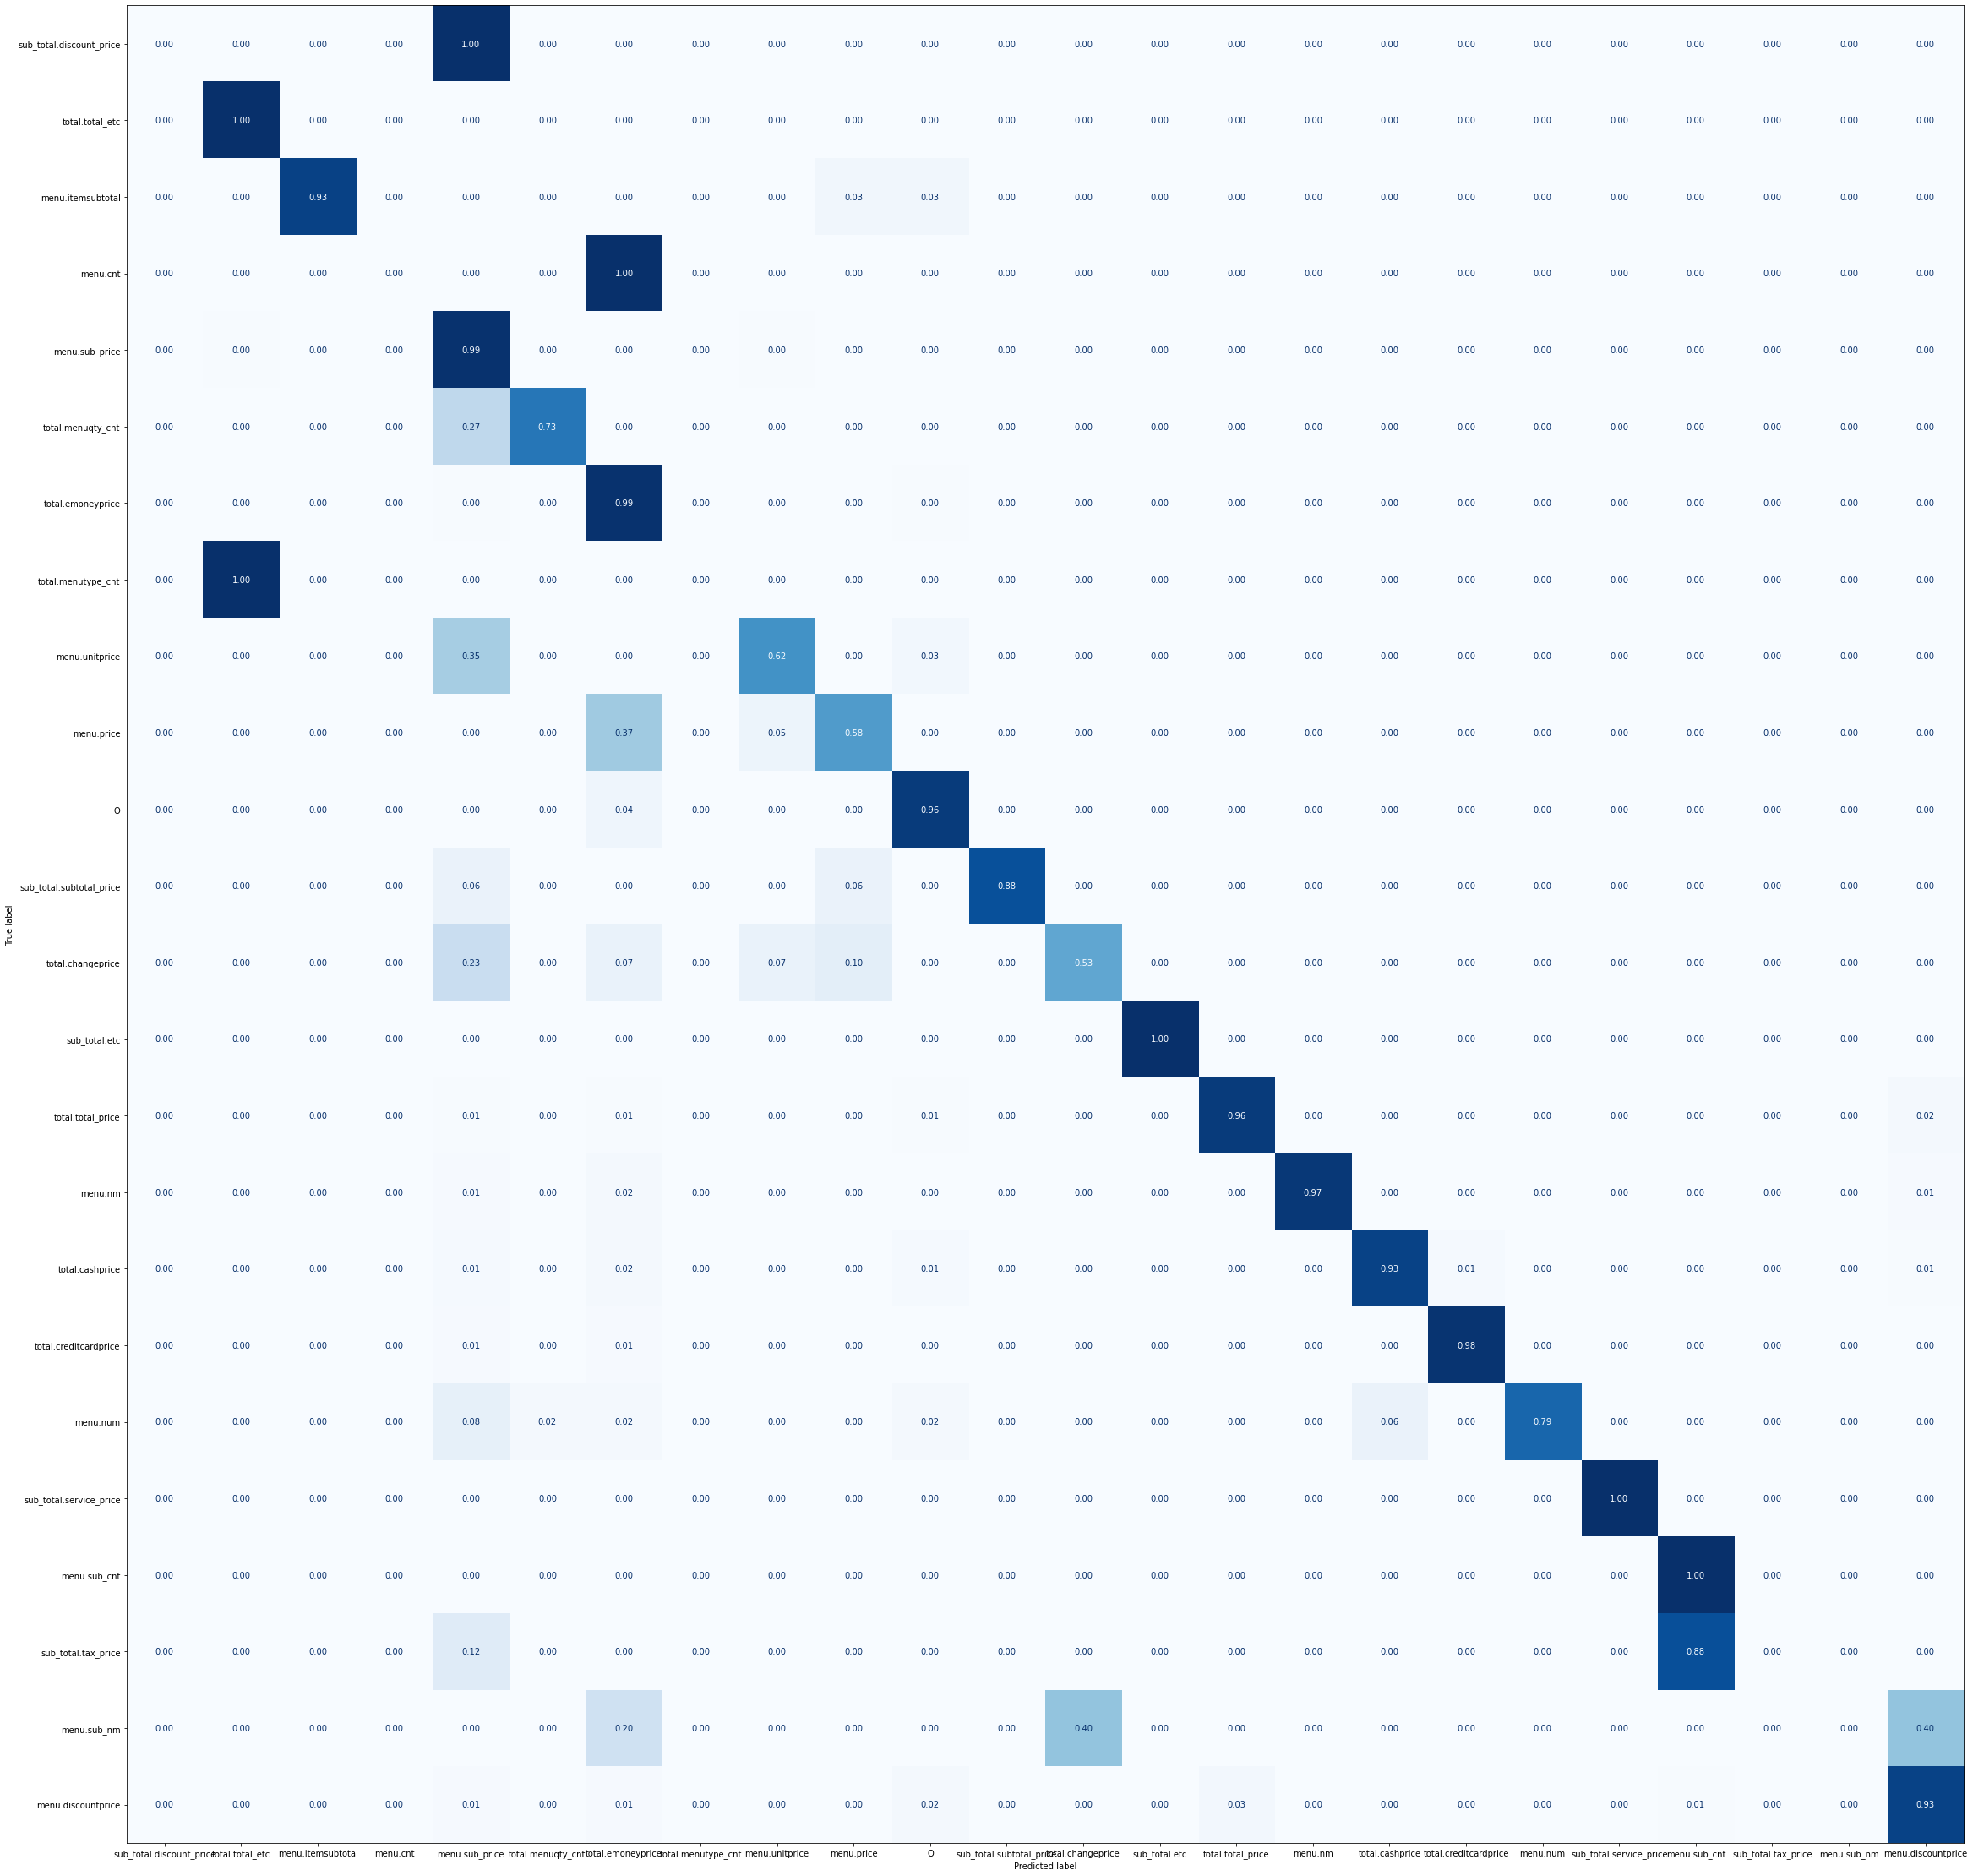

In [116]:
from matplotlib import figure
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import json
import itertools

def plot_confusion_matrix(y_preds,y_true,labels):
  cm = confusion_matrix(y_true,y_preds,normalize= "true")
  fig, ax = plt.subplots(figsize=(40,40))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
  disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=False)
  # plt.title("Normalized confusion matrix")
  plt.savefig(cord_folder_output_path+'conf_mat.pdf')
  plt.show()

def results_cm(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])


  return out_label_list,preds_list
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

# plot_confusion_matrix(preds_val, out_label_ids, labels)
# preds_val
out_label_list,preds_list =results_cm(preds_val, out_label_ids, labels)

out_label_list = list(itertools.chain(*out_label_list))
preds_list = list(itertools.chain(*preds_list))

data_conf = {'out_label_list':out_label_list,'preds_list':preds_list,'labels':labels}

with open(cord_folder_output_path+'data_conf.json', 'w', encoding='utf-8') as f:
    json.dump(data_conf, f, ensure_ascii=False, indent=4)


plot_confusion_matrix(preds_list,out_label_list, labels)